# Burger equation in 1D (PINN & SPINN)

We solve the following PDE:
$$
\begin{cases}
\frac{\partial}{\partial t} u(t,x) + u(t,x)\frac{\partial}{\partial x}
          u(t,x) - \theta \frac{\partial^2}{\partial x^2} u(t,x) = 0,\\
          u(0, x) = -\sin(\pi x), \text{ (initial condition)}\\
u(t,-1)=u(t,1)=0, \text{ (boundary condition)}
\end{cases}
$$

This has been studied in [this article](https://www.mdpi.com/2073-4441/13/4/423) for example.

To solve the PDE, we use both a classical PINN and a [Separable PINN](https://openreview.net/pdf?id=dEySGIcDnI) approach implemented in jinns. We see that, without any specific tuning the SPINN offers an important gain in speed and precision of the solution.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Float64 and GPU settings

In [2]:
#import os; os.environ["JAX_ENABLE_X64"] = "TRUE" # comment/uncomment to  disable/enable float64 for JAX
#import os; os.environ["CUDA_VISIBLE_DEVICES"]="" # If uncommented then GPU is disable

Import our package

In [3]:
import jinns

2024-03-27 18:32:07.731080: W external/xla/xla/service/platform_util.cc:198] unable to create StreamExecutor for CUDA:0: failed initializing StreamExecutor for CUDA device ordinal 0: INTERNAL: failed call to cuDevicePrimaryCtxRetain: CUDA_ERROR_UNKNOWN: unknown error
CUDA backend failed to initialize: INTERNAL: no supported devices found for platform CUDA (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/home/nicolas/Recherche/INRAE/PINN/jinns/jinns/utils/_pinn.py:161: SyntaxWarning: invalid escape sequence '\_'
  """


Import other dependencies

In [4]:
import jax
from jax import random, vmap
import jax.numpy as jnp
import equinox as eqx
from functools import partial
import matplotlib.pyplot as plt

key = random.PRNGKey(2)

Create the neural network architecture for the PINN

In [5]:
eqx_list = [
    ["Linear", 2, 128],
    ["tanh"],
    ["Linear", 128, 128],
    ["tanh"],
    ["Linear", 128, 128],
    ["tanh"],
    ["Linear", 128, 1]
]
key, subkey = random.split(key)
u_pinn = jinns.utils.create_PINN(subkey, eqx_list, "nonstatio_PDE", 1)

In [6]:
params_pinn = u_pinn.init_params()
params_pinn = {
    "nn_params":params_pinn,
    "eq_params":{
    }
}

In [7]:
nx = 500
val_xdata = jnp.linspace(0, 1, nx)
ntime = 500
val_times = jnp.linspace(0, 1, ntime)

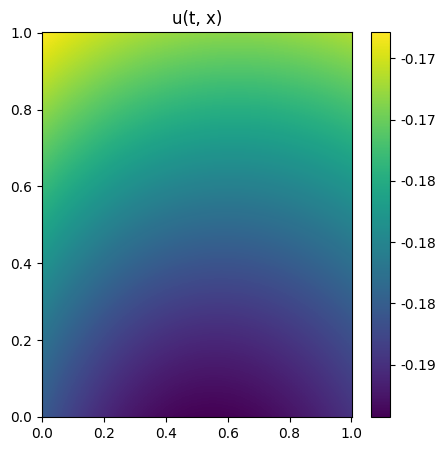

In [8]:
u_est_pinn = lambda t, x:u_pinn(t, x, params_pinn["nn_params"])
# same subkey
jinns.data.plot1d_image(u_est_pinn, xdata=val_xdata, times=val_times, cmap="viridis", colorbar=True, figsize=(5, 5), title="u(t, x)")

## Save the model and the keywords arguments that were used to create it

In [9]:
eqx.tree_serialise_leaves("test_save_load.eqx", u_pinn)
import pickle

filename = f"./test_save_load"  
with open(filename + "-parameters.pkl", 'wb') as f:
    pickle.dump(params_pinn , f)

kwargs = {
    "key": subkey,
    "eqx_list": eqx_list,
    "eq_type":"nonstatio_PDE",
    "dim_x":1
}
with open(filename + "-arguments.pkl", 'wb') as f:
    pickle.dump(kwargs , f)

## Reload model

In [10]:
with open(filename + "-parameters.pkl", 'rb') as f:
    params_pinn_reloaded = pickle.load(f)
with open(filename + "-arguments.pkl", 'rb') as f:
    arguments_pinn_reloaded = pickle.load(f)

In [11]:
u_pinn_reloaded_shallow = eqx.filter_eval_shape(jinns.utils.create_PINN, **arguments_pinn_reloaded)
u_pinn_reloaded = eqx.tree_deserialise_leaves("test_save_load.eqx", u_pinn_reloaded_shallow)

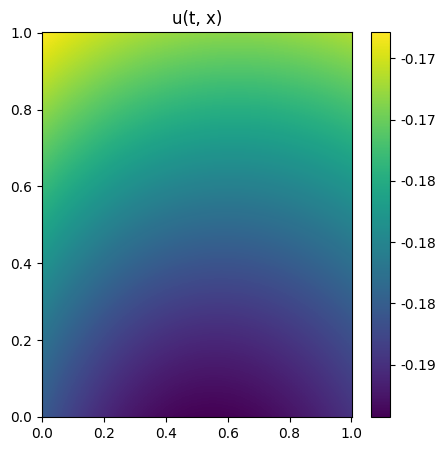

In [12]:
u_est_pinn_reloaded = lambda t, x:u_pinn_reloaded(t, x, params_pinn_reloaded["nn_params"])
# same subkey
jinns.data.plot1d_image(u_est_pinn_reloaded, xdata=val_xdata, times=val_times, cmap="viridis", colorbar=True, figsize=(5, 5), title="u(t, x)")

## Transform functions of eqx_list into str

In [23]:
eqx_list = [
    [eqx.nn.Linear, 3, 30],
    [jax.nn.tanh],
    [eqx.nn.Linear, 30, 30],
    [jax.nn.tanh],
    [eqx.nn.Linear, 30, 30],
    [jax.nn.tanh],
    [eqx.nn.Linear, 30, 1],
    [jnp.exp]
]

In [27]:
eqx_list[1][0].__name__

'tanh'

In [22]:
hasattr(jax.nn.tanh, '__call__')

True

In [24]:
jax.tree_util.tree_flatten(eqx_list)

([equinox.nn._linear.Linear,
  3,
  30,
  <PjitFunction of <function jax.numpy.tanh at 0x7f650b90a2a0>>,
  equinox.nn._linear.Linear,
  30,
  30,
  <PjitFunction of <function jax.numpy.tanh at 0x7f650b90a2a0>>,
  equinox.nn._linear.Linear,
  30,
  30,
  <PjitFunction of <function jax.numpy.tanh at 0x7f650b90a2a0>>,
  equinox.nn._linear.Linear,
  30,
  1,
  <PjitFunction of <function jax.numpy.exp at 0x7f650b8ff1a0>>],
 PyTreeDef([[*, *, *], [*], [*, *, *], [*], [*, *, *], [*], [*, *, *], [*]]))

In [26]:
# transform function eqx_list into their str representation
get_function_nodes = lambda ptr: tuple(elt for elt in eqx_list if hasattr(elt, '__call__'))
eqx_list_str = eqx.tree_at(where=get_function_nodes, pytree=eqx_list, replace_fn=lambda elt: elt.__name__)
eqx_list_str

[[equinox.nn._linear.Linear, 3, 30],
 [<PjitFunction of <function jax.numpy.tanh at 0x7f650b90a2a0>>],
 [equinox.nn._linear.Linear, 30, 30],
 [<PjitFunction of <function jax.numpy.tanh at 0x7f650b90a2a0>>],
 [equinox.nn._linear.Linear, 30, 30],
 [<PjitFunction of <function jax.numpy.tanh at 0x7f650b90a2a0>>],
 [equinox.nn._linear.Linear, 30, 1],
 [<PjitFunction of <function jax.numpy.exp at 0x7f650b8ff1a0>>]]

In [30]:
r = lambda elt: elt.__name__
r(eqx_list[1][0])

'tanh'

In [31]:
jax.nn.tanh.__name__

'tanh'